In [1]:
import sys, os, torch
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

if(torch.cuda.device_count() >= 1):
    device = "cuda:1"
else:
    device = 'cpu'

# move directory
os.chdir("..")

In [2]:
args_video = {
    "image_size" : 128, 
    "patch_size" : 16, 
    "n_frames" : 84, 
    "dim": 128, 
    "depth" : 2, 
    "n_heads" : 4, 
    "pool" : 'mean', 
    "in_channels" : 3, 
    "d_head" : 64, 
    "dropout" : 0.1,
    "embedd_dropout": 0.1, 
    "scale_dim" : 8,
}

args_0D = {
    "n_features" : 18, 
    "feature_dims" : 128,
    "max_len" : 84, 
    "n_layers" : 4,
    "n_heads" : 8,
    "dim_feedforward": 1024, 
    "dropout" : 0.1,
}

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from src.utils.utility import preparing_multi_data
from src.dataset import MultiModalDataset
from typing import List, Literal
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from src.models.MultiModal import MultiModalModel

root_dir = "./dataset/temp"
df_disrupt = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")

from src.config import Config
config = Config()
ts_cols = config.input_features

ts_filepath = "./dataset/KSTAR_Disruption_ts_data_5ms.csv"
(shot_train, ts_train), (shot_valid, ts_valid), (shot_test, ts_test), scaler = preparing_multi_data(root_dir, ts_filepath, ts_cols, scaler = 'Robust')
kstar_shot_list = pd.read_csv('./dataset/KSTAR_Disruption_Shot_List_extend.csv', encoding = "euc-kr")

train_data = MultiModalDataset(shot_train, df_disrupt, ts_train, ts_cols, augmentation=False, augmentation_args=None, crop_size=128, seq_len =84, dist = 0, dt = 1 / 210, scaler = scaler, tau = 1)
train_loader = DataLoader(train_data, batch_size = 1, num_workers = 1)

/home/zinzinbin/anaconda3/envs/research-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
extract the null data / short time data: 100%|██████████| 213/213 [00:01<00:00, 112.79it/s]


# check | video data : 6487, 0D data : 6487 | # of shot : 6487


In [4]:
''' ViViT attention rollout
- visualization of the vivit model using video data only
'''

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Literal, Optional

def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    result = result.repeat((21,1,1))
    
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (21, 1, 17, 17)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0).repeat((21,1,1))
            a = (attention_heads_fused + 1.0 * I) / 2.0
            
            result = torch.bmm(a, result)
            
    mask = result[:,0,1:]
    width = int(mask.size()[-1] ** 0.5)
    
    mask = mask.reshape(result.size()[0], 1, width, width)
    mask_interp = np.zeros((result.size()[0], 1, 128, 128))
    
    for idx in range(result.size()[0]):
        mask_interp[idx] = F.interpolate(mask[idx].view(1,1,width,width), size = (128,128), mode='bilinear', align_corners=False).numpy()

    mask_final = mask_interp / np.max(mask_interp)
    mask_final = np.max(mask_final, axis = 0).reshape(128,128,1)
    return mask_final

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class ViViTAttentionRollout:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'mean', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.named_modules():
            if layer_name in name and "space_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
        
    def __call__(self, input_tensor : torch.Tensor):
        self.attentions = []
        
        with torch.no_grad():
            output = self.model(input_tensor)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)
    
    
''' This part is for multimodal model
- same name but add "2" for separation
'''
    
def rollout2(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    result = result.repeat((84,1,1))
    
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (21, 1, 17, 17)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0).repeat((84,1,1))
            a = (attention_heads_fused + 1.0 * I) / 2.0
            
            result = torch.bmm(a, result)
            
    mask = result[:,0,1:]
    width = int(mask.size()[-1] ** 0.5)
    
    mask = mask.reshape(result.size()[0], 1, width, width)
    mask_interp = np.zeros((result.size()[0], 1, 128, 128))
    
    for idx in range(result.size()[0]):
        mask_interp[idx] = F.interpolate(mask[idx].view(1,1,width,width), size = (128,128), mode='bilinear', align_corners=False).numpy()

    mask_final = mask_interp / np.max(mask_interp)
    mask_final = np.max(mask_final, axis = 0).reshape(128,128,1)
    return mask_final

class ViViTAttentionRollout2:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'max', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.encoder_video.named_modules():
            if layer_name in name and "space_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.encoder_video.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.encoder_video.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
    
    def __call__(self, data, device):
        self.attentions = []
        
        with torch.no_grad():
            data_video = data['video'].to(device)
            data_0D = data['0D'].to(device)
            output = self.model(data_video, data_0D)
        
        return rollout2(self.attentions, self.discard_ratio, self.head_fusion)

In [5]:
from src.models.ViViT import ViViT

model = ViViT(
    image_size = 128,
    patch_size = 16,
    n_classes = 2,
    n_frames = 21,
    dim = 128,
    depth = 2,
    n_heads = 4,
    pool = "mean",
    in_channels = 3,
    d_head = 64,
    dropout = 0.1,
    embedd_dropout=0.1,
    scale_dim = 8
)

save_best_dir = "./weights/ViViT_clip_21_dist_3_Focal_DRW_seed_40_best.pt"
model.load_state_dict(torch.load(save_best_dir, map_location=torch.device('cpu')))

for name, module in model.named_modules():
    for name_, module_ in module.named_children():
        if "to_out" in name_ and "space_transformer" in name:
            print("name : {}, name_ : {}".format(name, name_))
            
import cv2
import numpy as np
import matplotlib.pyplot as plt

multi_model = MultiModalModel(
    2,
    args_video,
    args_0D
)

save_best_dir = "./weights/Multi-Modal_concat_clip_84_dist_5_Focal_RS_DRW_seed_42_best.pt"
multi_model.load_state_dict(torch.load(save_best_dir, map_location = "cpu"))


name : space_transformer.layers.0.0.fn, name_ : to_out
name : space_transformer.layers.1.0.fn, name_ : to_out


<All keys matched successfully>

In [6]:
def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar


In [7]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
multi_model.to(device)
multi_model.eval()

model.to(device)
model.eval()

ViViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=128, bias=True)
  )
  (space_transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=1024, bias=True)
              (1): GELU()
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=1024, out_features=128, bias=True)
              (4): Dropout(p=0.1, in

In [8]:
train_data.get_shot_num = True

In [9]:
for idx, (samples, sample_label, shot_num) in enumerate(train_loader):
    if sample_label == torch.Tensor([0]) and shot_num > 20000:
        break

In [10]:
shot_num

tensor([21119])

In [50]:
sample_data = samples['video']
sample_vivit = samples['video']

In [51]:
n_frame = 3

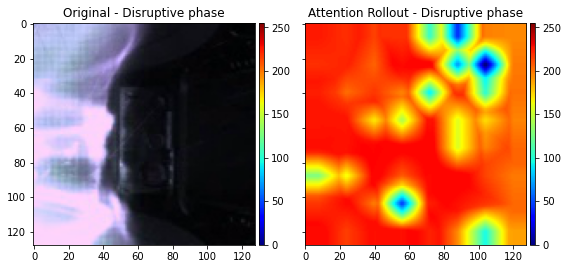

In [52]:
# ViViT case
sample_vivit = sample_vivit[:,:,-21:,:,:]
rollout_model = ViViTAttentionRollout(model,head_fusion = 'mean', discard_ratio=0.1)
att_mask = rollout_model(sample_vivit.to(device))

att_heatmap = cv2.applyColorMap(np.uint8(255 * att_mask), cv2.COLORMAP_JET)

img = sample_vivit[:,:,-n_frame,:,:].cpu().squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

att_result = att_heatmap / np.max(att_heatmap)
att_result = np.uint8(255 * att_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('Attention Rollout - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(att_result[:,:,::1], cmap = plt.cm.get_cmap('jet'))

add_colorbar(im1)
add_colorbar(im2)

fig.tight_layout()

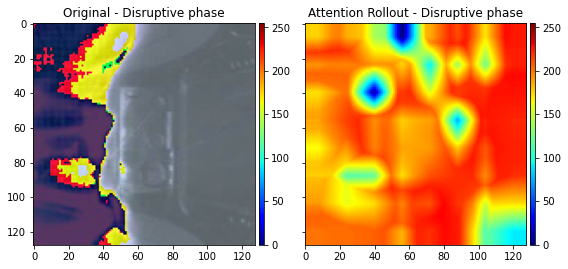

In [53]:
# multimodal case
rollout_model = ViViTAttentionRollout2(multi_model, head_fusion = 'mean', discard_ratio=0.1)
att_mask = rollout_model(samples, device)
att_heatmap = cv2.applyColorMap(np.uint8(255 * att_mask), cv2.COLORMAP_JET)

sample_data = samples['video']
img = sample_data[:,:,-n_frame,:,:].cpu().squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

att_result = att_heatmap / np.max(att_heatmap)
att_result = np.uint8(255 * att_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('Attention Rollout - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(att_result[:,:,::1], cmap = plt.cm.get_cmap('jet'))

add_colorbar(im1)
add_colorbar(im2)

fig.tight_layout()

/home/zinzinbin/anaconda3/envs/research-env/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


activations :  torch.Size([1, 128, 3, 8, 8])
gradients :  torch.Size([1, 128, 3, 8, 8])
grad cam map :  torch.Size([1, 1, 3, 8, 8])


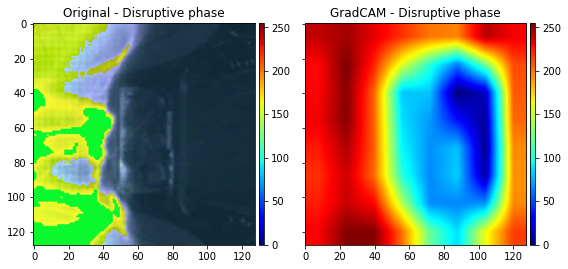

In [57]:
# GradCAM : R2Plus1D case
from src.models.R2Plus1D import R2Plus1DClassifier

model = R2Plus1DClassifier(
    input_size  = (3,21,128,128),
    num_classes = 2, 
    layer_sizes = [1,2,2,1],
    pretrained = False, 
    alpha = 1.0
)

save_best_dir = "./weights/R2Plus1D_clip_21_dist_5_Focal_DRW_seed_40_best.pt"
model.load_state_dict(torch.load(save_best_dir, map_location = "cpu"))

model.to(device)

# activations
feature_blobs = []

# gradients
backward_feature = []

import torch.nn as nn

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module:nn.Module, input, output):
    feature_blobs.append(output.cpu().data)
    

# Grad-CAM
def backward_hook(module:nn.Module, input, output):
    backward_feature.append(output[0])
    
finalconv_name = "conv5"

model._modules['res2plus1d'].get_submodule("conv5").register_forward_hook(hook_feature)
model._modules['res2plus1d'].get_submodule("conv5").register_backward_hook(backward_hook)

sample_data = samples['video'][:,:,-21:,:,:]

model.eval()
sample_logit = model(sample_data.to(device))
sample_data.cpu()
sample_output = torch.nn.functional.softmax(sample_logit, dim = 1).data.squeeze()

score = sample_logit[:,0].squeeze()
score.backward(retain_graph = True)

activations = feature_blobs[-1].to(device) # (1, 512, 7, 7), forward activations
gradients = backward_feature[-1] # (1, 512, 7, 7), backward gradients

print("activations : ", activations.size())
print("gradients : ", gradients.size())

alpha = gradients.mean(2) # time axis average
alpha = alpha.view(1, 128, -1).mean(2) # average for all spatial axis
weights = alpha.view(1, 128, 1, 1, 1)

import torch.nn.functional as F

grad_cam_map = (weights*activations).sum(1, keepdim = True)
grad_cam_map = F.relu(grad_cam_map).view(1,1,3,8,8)

print("grad cam map : ", grad_cam_map.size())

grad_cam_map_interp = torch.empty((1,1,3,128,128))

for idx in range(3):
   grad_cam_map_interp[:,:,idx,:,:] = F.interpolate(grad_cam_map[:,:,idx,:,:], size=(128, 128), mode='bilinear', align_corners=False)

grad_cam_map_interp = grad_cam_map_interp.mean(2)
map_min, map_max = grad_cam_map_interp.min(), grad_cam_map_interp.max()
grad_cam_map = (grad_cam_map_interp - map_min).div(map_max - map_min).data

import cv2
import numpy as np
import matplotlib.pyplot as plt

grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET)

# normalize [90.0, 98.0, 102.0]
img = sample_data[:,:,-n_frame,:,:].squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

# grad_result = grad_heatmap + img
grad_result = grad_heatmap
grad_result = grad_result / np.max(grad_result)
grad_result = np.uint8(255 * grad_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('GradCAM - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(grad_result, cmap = plt.cm.get_cmap('jet'))

add_colorbar(im1)
add_colorbar(im2)
fig.tight_layout()

SlowNet | activations :  torch.Size([1, 512, 5, 4, 4])
SlowNet | gradients :  torch.Size([1, 512, 5, 4, 4])
FastNet | activations :  torch.Size([1, 64, 5, 8, 8])
FastNet | gradients :  torch.Size([1, 64, 5, 8, 8])


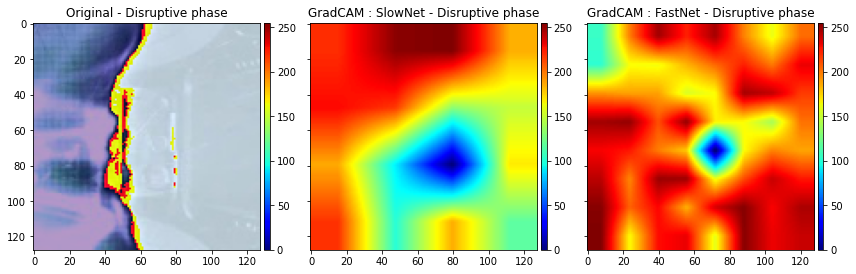

In [55]:
# GradCAM : SlowFast
from src.models.resnet import Bottleneck3D
from src.models.slowfast import SlowFast

model = SlowFast(
    input_shape = (3, 20, 128, 128),
    block = Bottleneck3D,
    layers = [1,2,2,1],
    alpha = 4,
    tau_fast = 1,
    num_classes = 2,
    alpha_elu = 1.0,
)

save_best_dir = "./weights/SlowFast_clip_20_dist_5_Focal_DRW_seed_40_best.pt"
model.load_state_dict(torch.load(save_best_dir, map_location="cpu"))

model.to(device)

# activations 
feature_blobs_sn = []
feature_blobs_fn = []

# gradients
backward_feature_sn = []
backward_feature_fn = []

import torch.nn as nn

def hook_feature_sn(module:nn.Module, input, output):
    feature_blobs_sn.append(output.cpu().data)
    
# Grad-CAM
def backward_hook_sn(module:nn.Module, input, output):
    backward_feature_sn.append(output[0])
    
def hook_feature_fn(module:nn.Module, input, output):
    feature_blobs_fn.append(output.cpu().data)
    
# Grad-CAM
def backward_hook_fn(module:nn.Module, input, output):
    backward_feature_fn.append(output[0])
    
# SlowFast model has 2 stream line
model._modules['encoder']._modules['slownet']._modules['layer4']._modules['0']._modules['downsample'].get_submodule("0").register_forward_hook(hook_feature_sn)
model._modules['encoder']._modules['slownet']._modules['layer4']._modules['0']._modules['downsample'].get_submodule("0").register_backward_hook(backward_hook_sn)

# FastNet
model._modules['encoder']._modules['fastnet'].get_submodule('l_layer3').register_forward_hook(hook_feature_fn)
model._modules['encoder']._modules['fastnet'].get_submodule('l_layer3').register_backward_hook(backward_hook_fn)

model.eval()
sample_data = samples['video'][:,:,-20:,:,:]

sample_logit = model(sample_data.to(device))
sample_data.cpu()
sample_output = torch.nn.functional.softmax(sample_logit, dim = 1).data.squeeze()

score = sample_logit[:,0].squeeze()
score.backward(retain_graph = True)

activations_sn = feature_blobs_sn[-1].to(device) # (1, 512, 7, 7), forward activations
gradients_sn = backward_feature_sn[-1] # (1, 512, 7, 7), backward gradients

print("SlowNet | activations : ", activations_sn.size())
print("SlowNet | gradients : ", gradients_sn.size())

activations_fn = feature_blobs_fn[-1].to(device) # (1, 512, 7, 7), forward activations
gradients_fn = backward_feature_fn[-1] # (1, 512, 7, 7), backward gradients

print("FastNet | activations : ", activations_fn.size())
print("FastNet | gradients : ", gradients_fn.size())

alpha = gradients_sn.mean(2) # time axis average
alpha = alpha.view(1, 512, -1).mean(2) # average for all spatial axis
weights_sn = alpha.view(1, 512, 1, 1, 1)

alpha = gradients_fn.mean(2) # time axis average
alpha = alpha.view(1, 64, -1).mean(2) # average for all spatial axis
weights_fn = alpha.view(1, 64, 1, 1, 1)

import torch.nn.functional as F

# case : SlowNet 
grad_cam_map = (weights_sn*activations_sn).sum(1, keepdim = True)
grad_cam_map = F.relu(grad_cam_map).view(1,1,5,4,4)

grad_cam_map_interp = torch.empty((1,1,5,128,128))

for idx in range(5):
   grad_cam_map_interp[:,:,idx,:,:] = F.interpolate(grad_cam_map[:,:,idx,:,:], size=(128, 128), mode='bilinear', align_corners=False)

grad_cam_map_interp = grad_cam_map_interp.mean(2)
map_min, map_max = grad_cam_map_interp.min(), grad_cam_map_interp.max()
grad_cam_map_sn = (grad_cam_map_interp - map_min).div(map_max - map_min).data

# case : FastNet 
grad_cam_map = (weights_fn*activations_fn).sum(1, keepdim = True)
grad_cam_map = F.relu(grad_cam_map).view(1,1,5,8,8)

grad_cam_map_interp = torch.empty((1,1,5,128,128))

for idx in range(5):
   grad_cam_map_interp[:,:,idx,:,:] = F.interpolate(grad_cam_map[:,:,idx,:,:], size=(128, 128), mode='bilinear', align_corners=False)

grad_cam_map_interp = grad_cam_map_interp.mean(2)
map_min, map_max = grad_cam_map_interp.min(), grad_cam_map_interp.max()
grad_cam_map_fn = (grad_cam_map_interp - map_min).div(map_max - map_min).data

grad_heatmap_sn = cv2.applyColorMap(np.uint8(255 * grad_cam_map_sn.squeeze().cpu()), cv2.COLORMAP_JET)
grad_heatmap_fn = cv2.applyColorMap(np.uint8(255 * grad_cam_map_fn.squeeze().cpu()), cv2.COLORMAP_JET)

img = sample_data[:,:,-n_frame,:,:].squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

grad_result_sn= grad_heatmap_sn 
grad_result_sn= grad_result_sn / np.max(grad_result_sn)
grad_result_sn= np.uint8(255 * grad_result_sn)

grad_result_fn= grad_heatmap_fn 
grad_result_fn= grad_result_fn / np.max(grad_result_fn)
grad_result_fn= np.uint8(255 * grad_result_fn)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 12), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('GradCAM : SlowNet - {}'.format(title))
ax3.set_title('GradCAM : FastNet - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(grad_result_sn, cmap = plt.cm.get_cmap('jet'))
im3 = ax3.imshow(grad_result_fn, cmap = plt.cm.get_cmap('jet'))

add_colorbar(im1)
add_colorbar(im2)
add_colorbar(im3)

fig.tight_layout()